# Network Traffic Forecasting: Simulation Demo

This notebook validates the forecasting pipeline using synthetic data. 
It simulates multiple days of network traffic (sine waves with noise) to benchmark Prophet vs. DeepAR.

**Goal:** Train on historic cycles and predict the full next cycle (Next Day Forecast).

In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- SYSTEM IMPORTS ---
from config import Config
from data_processor import DatasetMeta
from models import ProphetAdapter, DeepARAdapter
from visualizer import plot_model_comparison, save_metrics

# --- COMPATIBILITY PATCHES ---
try:
    import gluonts.torch.util
    # Fix for Python 3.12+ array slicing issues in GluonTS
    gluonts.torch.util.take_slice = lambda a, idx: a[tuple(idx)] if isinstance(idx, list) else a[idx]
except ImportError:
    pass

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Configuration Strategy
We override specific `Config` defaults to suit the synthetic data environment. 

**Crucial Change for DeepAR:** We simulate **15 cycles** (days) instead of 3. Deep Learning models require sufficient repetition to separate signal from noise.

In [12]:
# Initialize default config
cfg = Config()

# --- SIMULATION PARAMETERS ---
cfg.DT = 2.0               # 2-second granularity
CYCLE_LEN = 600            # Duration of one "day" pattern in seconds
NUM_CYCLES = 15            # Total history to generate (Increase this for better DeepAR results)

# --- MODEL HYPERPARAMETERS ---
# Increase epochs slightly to ensure convergence on synthetic data
cfg.EPOCHS = 50           
# Look back 2 full cycles to make a prediction
cfg.CONTEXT_LENGTH_MULTIPLIER = 2 

# --- SPLIT STRATEGY ---
# We want to test exactly on the FINAL cycle (The last "Day")
total_bins = int((CYCLE_LEN * NUM_CYCLES) / cfg.DT)
bins_per_cycle = int(CYCLE_LEN / cfg.DT)

# Set max test samples to exactly one cycle length
cfg.MAX_TEST_SAMPLES = bins_per_cycle
# Set ratio to ensure we cut off exactly the last cycle
cfg.TEST_SPLIT_RATIO = 1.0 / NUM_CYCLES

print(f"Simulation Config: {NUM_CYCLES} Cycles of {CYCLE_LEN}s.")
print(f"Total Data Points: {total_bins}")
print(f"Test Horizon: {bins_per_cycle} points (1 Cycle)")

Simulation Config: 15 Cycles of 600s.
Total Data Points: 4500
Test Horizon: 300 points (1 Cycle)


## 2. Data Generation Factory
We create a robust generator that mimics daily network traffic volume (Morning rise, Noon peak, Night lull).

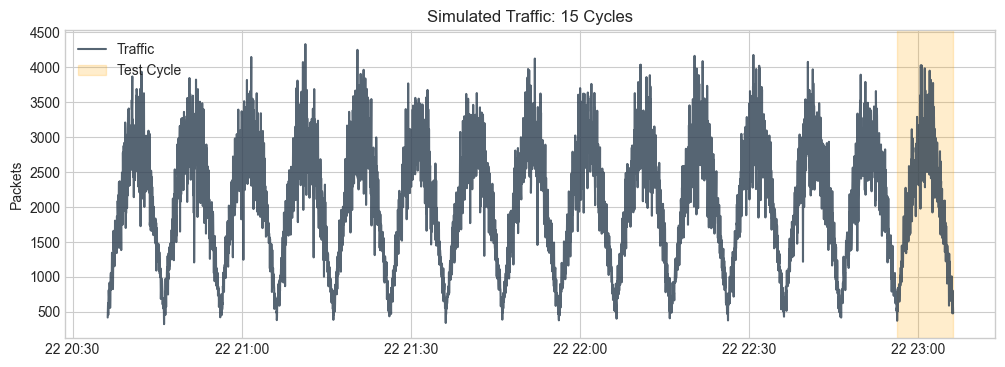

In [13]:
def generate_traffic(config, cycle_len_sec, n_cycles):
    """
    Generates a sine-wave based traffic pattern with random noise.
    Returns: DataFrame, DatasetMeta
    """
    steps_per_cycle = int(cycle_len_sec / config.DT)
    total_steps = steps_per_cycle * n_cycles
    
    # 1. Time Axis
    t_vals = np.arange(total_steps) * config.DT
    start_date = datetime.now()
    timestamps = [start_date + timedelta(seconds=t) for t in t_vals]
    
    # 2. Signal Generation (Sine Wave 0 to Pi representing Day/Night)
    # We map one cycle to [0, pi] so sin(x) goes 0 -> 1 -> 0
    cycle_progress = (t_vals % cycle_len_sec) / cycle_len_sec * np.pi
    
    # Base Bandwidth + Peak Amplitude
    intensity = 2.0 + (10.0 * np.sin(cycle_progress))
    
    # 3. Convert to Packet Counts (Rough approximation)
    # packets = (Mbps * 1e6 * dt) / (8 bits/byte * ~1000 bytes/packet)
    base_packets = (intensity * 1e6 * config.DT) / 8000
    
    # 4. Add Heteroscedastic Noise (Noise increases with volume)
    noise_scale = base_packets * 0.15  # 15% variance
    noise = np.random.normal(0, noise_scale, size=len(base_packets))
    
    # Ensure non-negative
    final_packets = np.maximum(10, base_packets + noise)
    
    df = pd.DataFrame({'timestamp': timestamps, 'target': final_packets})
    
    # 5. Construct Metadata manually since we skipped the processor
    meta = DatasetMeta(
        period_seconds=cycle_len_sec,
        bins_per_cycle=steps_per_cycle,
        total_cycles=n_cycles,
        detection_method="Simulation (Manual)"
    )
    
    return df, meta

# Generate
df_sim, meta = generate_traffic(cfg, CYCLE_LEN, NUM_CYCLES)

# Visual Sanity Check
plt.figure(figsize=(12, 4))
plt.plot(df_sim['timestamp'], df_sim['target'], color='#2c3e50', alpha=0.8, label='Traffic')
# Highlight Test Region
test_start_idx = len(df_sim) - cfg.MAX_TEST_SAMPLES
plt.axvspan(df_sim['timestamp'].iloc[test_start_idx], df_sim['timestamp'].iloc[-1], 
            color='orange', alpha=0.2, label='Test Cycle')
plt.title(f"Simulated Traffic: {NUM_CYCLES} Cycles")
plt.ylabel("Packets")
plt.legend()
plt.show()

## 3. Model Training & Evaluation
We run the models using the unified interface defined in `models.py`.

In [9]:
results_store = {}
metrics_store = []

pipeline = [
    ("Prophet", ProphetAdapter(cfg, meta)),
    ("DeepAR", DeepARAdapter(cfg, meta))
]

print("--- Pipeline Execution ---")
for name, model in pipeline:
    print(f"\n> Processing {name}...")
    
    # 1. Prepare (Split)
    model.prepare_data(df_sim)
    
    # 2. Train
    model.train()
    
    # 3. Predict
    forecast_df = model.predict()
    results_store[name] = forecast_df
    
    # 4. Metric Calculation
    mae = (forecast_df['actual'] - forecast_df['mean']).abs().mean()
    rmse = np.sqrt(((forecast_df['actual'] - forecast_df['mean']) ** 2).mean())
    print(f"  {name} MAE: {mae:.2f} | RMSE: {rmse:.2f}")

print("\nDone.")

19:54:47 - cmdstanpy - INFO - Chain [1] start processing


--- Pipeline Execution ---

> Processing Prophet...


19:54:47 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type        | Params | Mode  | In sizes                                                       | Out sizes    
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | train | [[1, 1], [1, 1], [1, 691, 7], [1, 691], [1, 691], [1, 300, 7]] | [1, 100, 300]
-------------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


  Prophet MAE: 256.34 | RMSE: 340.91

> Processing DeepAR...
Epoch 0: |          | 50/? [00:14<00:00,  3.38it/s, v_num=81, train_loss=7.770]

Epoch 0, global step 50: 'train_loss' reached 7.76784 (best 7.76784), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:15<00:00,  3.27it/s, v_num=81, train_loss=6.950]

Epoch 1, global step 100: 'train_loss' reached 6.95379 (best 6.95379), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:14<00:00,  3.35it/s, v_num=81, train_loss=6.830]

Epoch 2, global step 150: 'train_loss' reached 6.82709 (best 6.82709), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:14<00:00,  3.37it/s, v_num=81, train_loss=6.740]

Epoch 3, global step 200: 'train_loss' reached 6.73965 (best 6.73965), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:14<00:00,  3.48it/s, v_num=81, train_loss=6.820]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: |          | 50/? [00:14<00:00,  3.51it/s, v_num=81, train_loss=6.730]

Epoch 5, global step 300: 'train_loss' reached 6.73302 (best 6.73302), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:14<00:00,  3.51it/s, v_num=81, train_loss=6.710]

Epoch 6, global step 350: 'train_loss' reached 6.71129 (best 6.71129), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:14<00:00,  3.46it/s, v_num=81, train_loss=6.730]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:14<00:00,  3.55it/s, v_num=81, train_loss=6.730]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:14<00:00,  3.49it/s, v_num=81, train_loss=6.690]

Epoch 9, global step 500: 'train_loss' reached 6.68717 (best 6.68717), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:14<00:00,  3.45it/s, v_num=81, train_loss=6.740]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:14<00:00,  3.42it/s, v_num=81, train_loss=6.740]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:14<00:00,  3.44it/s, v_num=81, train_loss=6.690]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:14<00:00,  3.56it/s, v_num=81, train_loss=6.740]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:14<00:00,  3.47it/s, v_num=81, train_loss=6.770]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:14<00:00,  3.47it/s, v_num=81, train_loss=6.730]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:13<00:00,  3.60it/s, v_num=81, train_loss=6.730]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:14<00:00,  3.51it/s, v_num=81, train_loss=6.710]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:14<00:00,  3.51it/s, v_num=81, train_loss=6.700]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:13<00:00,  3.59it/s, v_num=81, train_loss=6.720]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:14<00:00,  3.51it/s, v_num=81, train_loss=6.680]

Epoch 20, global step 1050: 'train_loss' reached 6.67874 (best 6.67874), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:14<00:00,  3.55it/s, v_num=81, train_loss=6.700]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:14<00:00,  3.55it/s, v_num=81, train_loss=6.700]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.690]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:13<00:00,  3.57it/s, v_num=81, train_loss=6.690]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:14<00:00,  3.50it/s, v_num=81, train_loss=6.690]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:13<00:00,  3.60it/s, v_num=81, train_loss=6.710]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:14<00:00,  3.57it/s, v_num=81, train_loss=6.690]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:14<00:00,  3.54it/s, v_num=81, train_loss=6.680]

Epoch 28, global step 1450: 'train_loss' reached 6.67519 (best 6.67519), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=28-step=1450.ckpt' as top 1


Epoch 29: |          | 50/? [00:14<00:00,  3.49it/s, v_num=81, train_loss=6.700]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.640]

Epoch 30, global step 1550: 'train_loss' reached 6.63635 (best 6.63635), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:14<00:00,  3.49it/s, v_num=81, train_loss=6.670]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:14<00:00,  3.55it/s, v_num=81, train_loss=6.700]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.680]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.670]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:14<00:00,  3.48it/s, v_num=81, train_loss=6.680]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:13<00:00,  3.64it/s, v_num=81, train_loss=6.710]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:13<00:00,  3.66it/s, v_num=81, train_loss=6.630]

Epoch 37, global step 1900: 'train_loss' reached 6.63250 (best 6.63250), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.630]

Epoch 38, global step 1950: 'train_loss' reached 6.62605 (best 6.62605), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:14<00:00,  3.49it/s, v_num=81, train_loss=6.630]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:14<00:00,  3.56it/s, v_num=81, train_loss=6.630]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:14<00:00,  3.54it/s, v_num=81, train_loss=6.620]

Epoch 41, global step 2100: 'train_loss' reached 6.62089 (best 6.62089), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: |          | 50/? [00:14<00:00,  3.56it/s, v_num=81, train_loss=6.630]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:14<00:00,  3.56it/s, v_num=81, train_loss=6.640]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:14<00:00,  3.56it/s, v_num=81, train_loss=6.600]

Epoch 44, global step 2250: 'train_loss' reached 6.59938 (best 6.59938), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=44-step=2250.ckpt' as top 1


Epoch 45: |          | 50/? [00:14<00:00,  3.52it/s, v_num=81, train_loss=6.660]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:13<00:00,  3.65it/s, v_num=81, train_loss=6.590]

Epoch 46, global step 2350: 'train_loss' reached 6.59485 (best 6.59485), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:12<00:00,  3.93it/s, v_num=81, train_loss=6.620]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:13<00:00,  3.83it/s, v_num=81, train_loss=6.660]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:13<00:00,  3.83it/s, v_num=81, train_loss=6.590]

Epoch 49, global step 2500: 'train_loss' reached 6.59054 (best 6.59054), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_81/checkpoints/epoch=49-step=2500.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:13<00:00,  3.83it/s, v_num=81, train_loss=6.590]
  DeepAR MAE: 268.18 | RMSE: 354.81

Done.


## 4. Visualization
Comparing the actual ground truth against the model forecasts.

✓ Saved comparison plot: output/demo_results.png


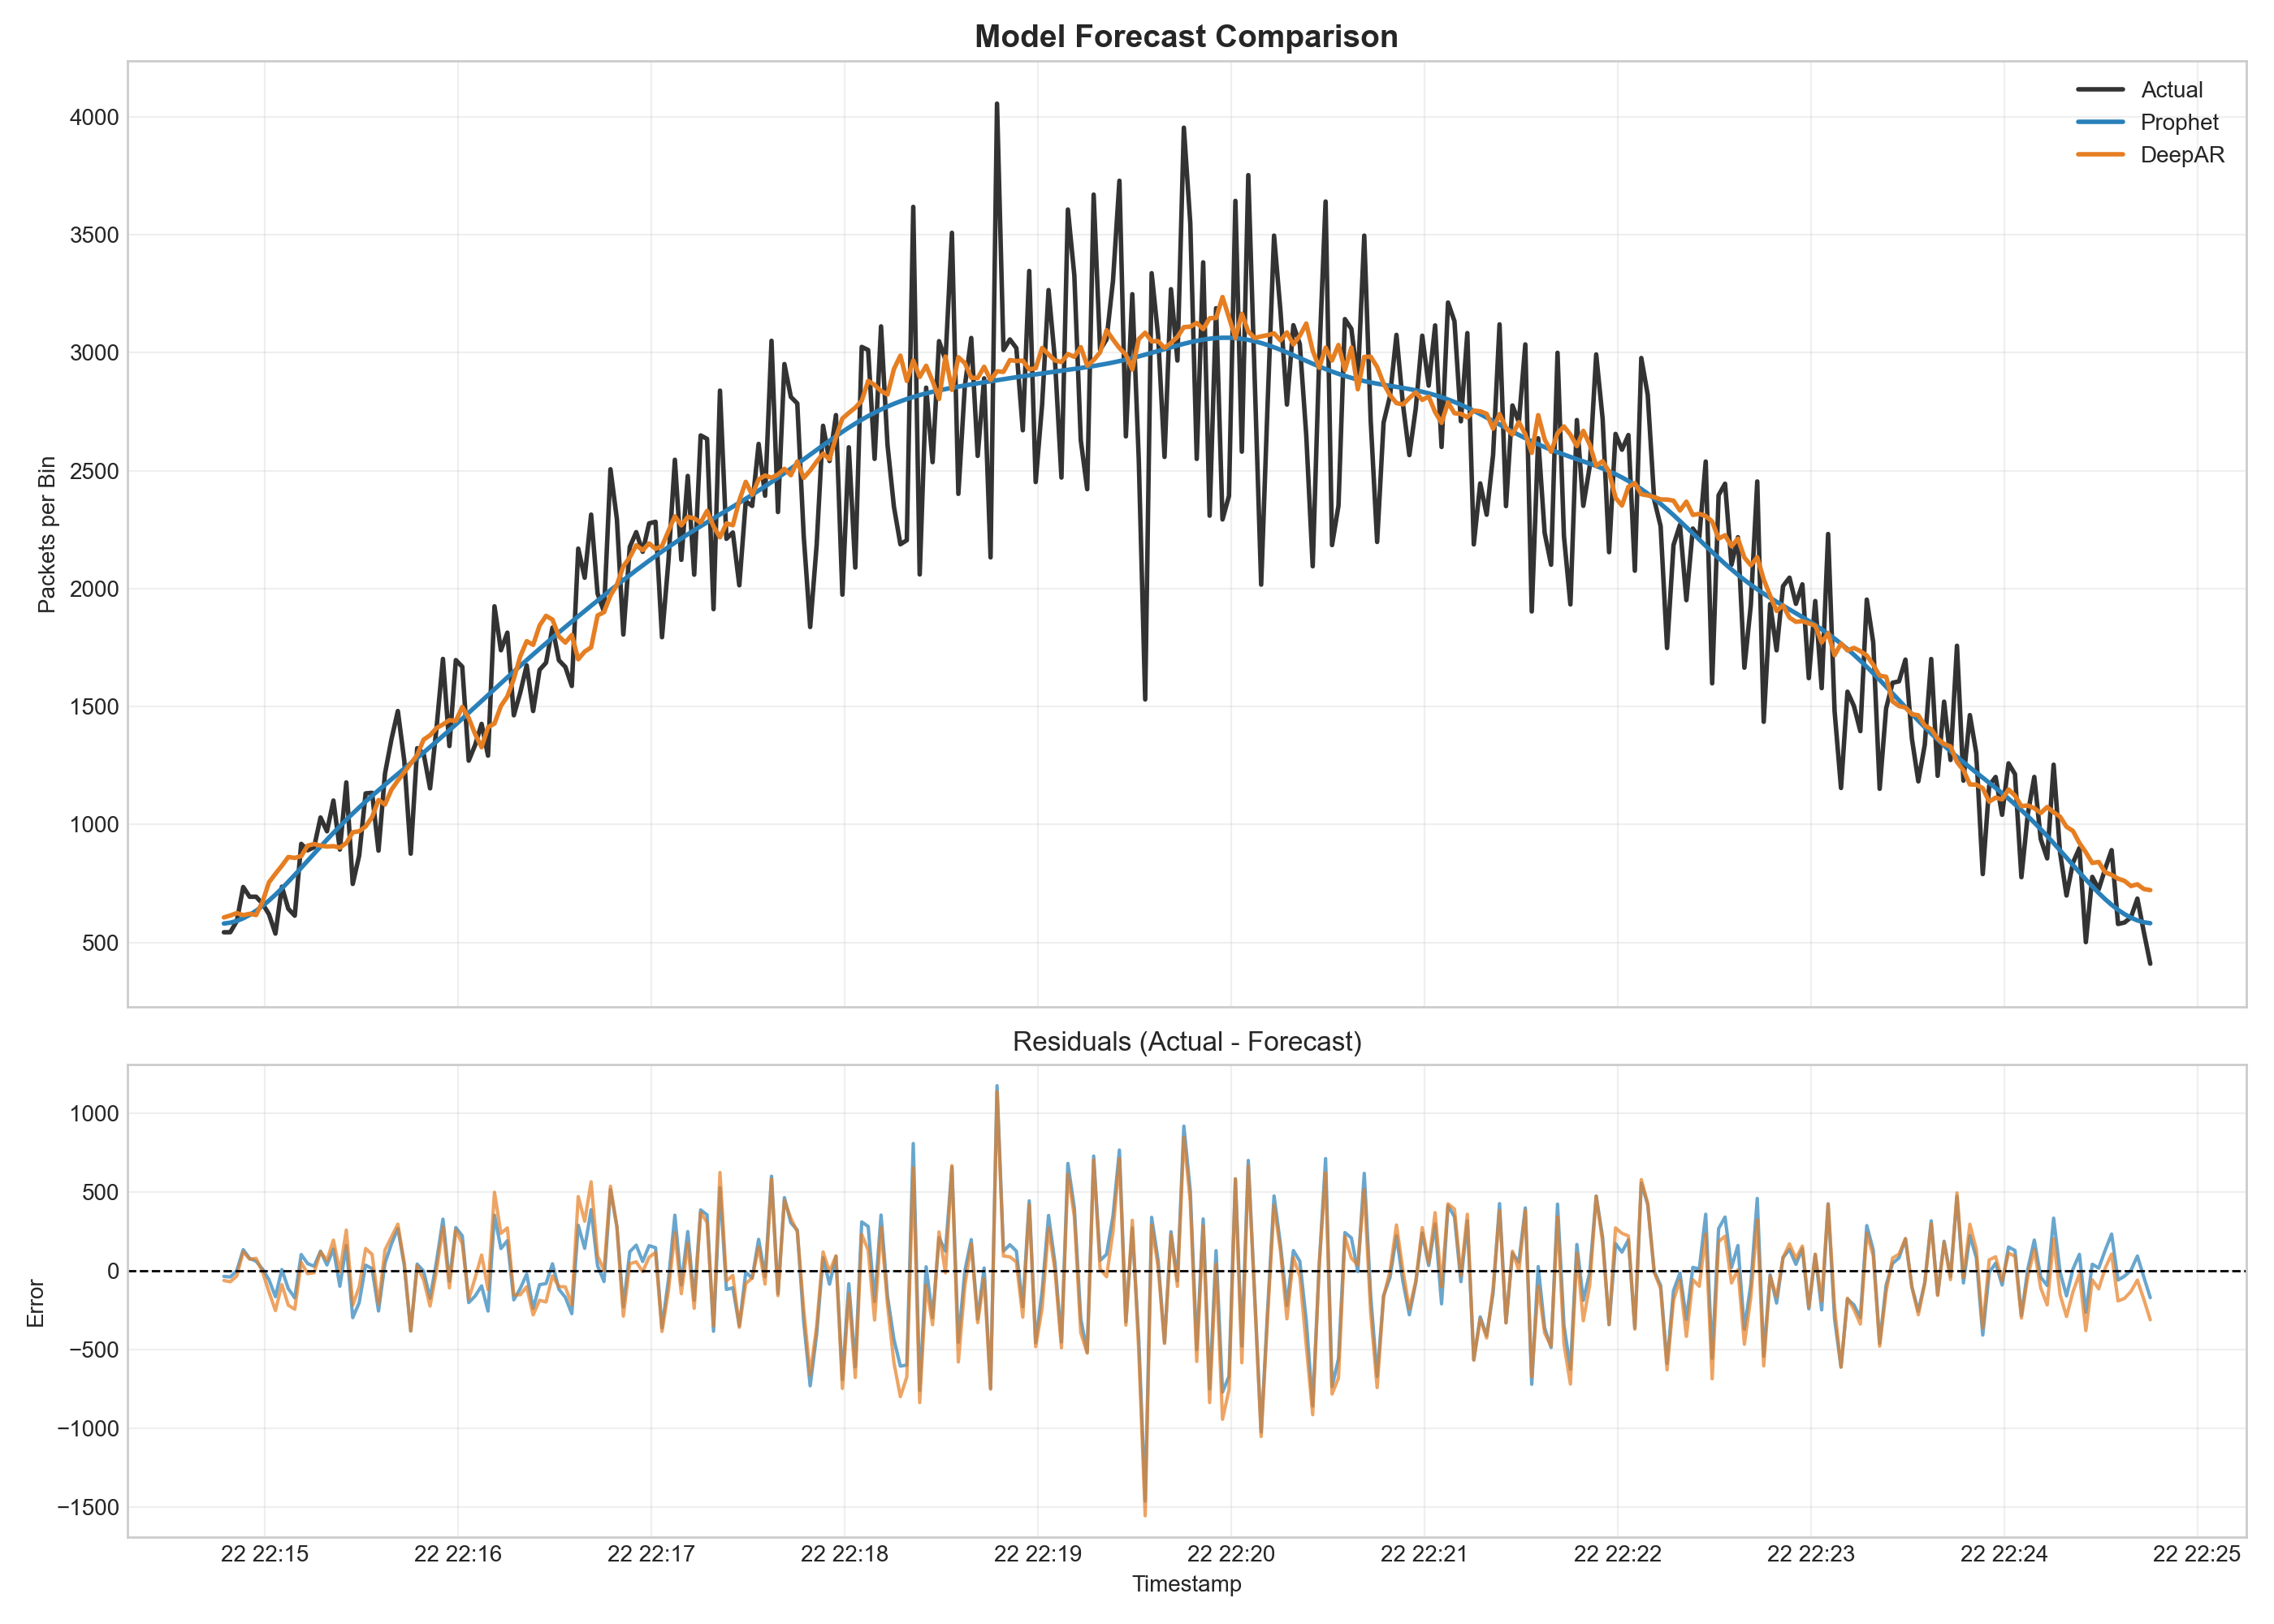

In [10]:
output_file = cfg.OUTPUT_DIR / "demo_results.png"
plot_model_comparison(results_store, output_file)

# Display in Notebook
from IPython.display import Image, display
display(Image(filename=output_file))